## Soilmoisture analysis for Mozambique

The aim of this notebook is to show and teach a possible workflow for analyzing and manipulating soil moisture data in Mozambique retrieved from ground measurements and ASCAT satellite data. Due to the given ground measurement data retrieved from zentracloud.com we focus on 5 different areas Buzi, Chokwé, Mabalane, Mabote and Muanza. The ASCAT satellite data is provided by TU Wien.

 The first two points in the workflow mapping and plotting are already worked out. Nonetheless you can familarize yourself with the code and try out some modifications yourself. Data analysis and manipulation is to be done by yourself though the notebook gives you some hints about what you could focus on. 

### Workflow

##### 1. Mapping the areas of interest

##### 2. Plotting the data

##### 3. Data analysis and manipulation 

_____________________________

At first we need to import necessary packages.


In [2]:
from datetime import datetime
import numpy as np
import xarray as xr
import geopandas as gpd
import osmnx as ox
import os
import folium
import pandas as pd
import matplotlib.pyplot as plt

##### 1. Mapping the areas of interest

When working with Earth observation data, we often need a bounding box, which is a rectangular shape on the map, to specify the observed area. The code below retrieves the bouning boxes for each area defined in area_names from OpenStreetMap.

In [3]:
area_names =["Buzi","Chokwé","Mabalane","Mabote","Muanza"]


def bbox (area_names):


    area_dict = dict()

    for area_name in area_names:

        # Get GeoDataFrame from OpenStreetMap
        gdf = ox.geocode_to_gdf(area_name)
        # Get bounding box [minx, miny, maxx, maxy]
        bbox = gdf.total_bounds  

        # To get a proper bounding box for processing later on in the shape of [min_lon, max_lon, min_lat, max_lat]
        bbox= [float(bbox[0]), float(bbox[2]), float(bbox[1]), float(bbox[3])] 

        area_dict[area_name] = bbox
    
    return(area_dict)


area_dict = bbox(area_names)

print(area_dict)

{'Buzi': [33.8931254, 34.8127126, -20.5695588, -19.582687], 'Chokwé': [32.5596257, 33.5225846, -24.8651389, -24.1120627], 'Mabalane': [32.2377105, 33.2483723, -24.1967515, -22.9668694], 'Mabote': [33.1611587, 34.6342067, -22.9057726, -21.3023939], 'Muanza': [34.4736235, 35.6973266, -19.5313462, -18.6416478]}


To visualize the bounding boxes from above on a map we use a popular package called folium which allows interaction with the map. Try clicking on the red bounding boxes and the name of the area will pop up.

In [4]:
def map(obs_area, area_dict):
        
    # Get GeoDataFrame from OpenStreetMap
    gdf = ox.geocode_to_gdf(obs_area)
    # Get bounding box [minx, miny, maxx, maxy]
    bbox = gdf.total_bounds 
    # To get a proper bounding box for processing later on in the shape of [min_lon, max_lon, min_lat, max_lat]
    bbox = [float(bbox[0]), float(bbox[2]), float(bbox[1]), float(bbox[3])] 
    # Get center point
    cent_p = [(bbox[2] + bbox[3])/2, (bbox[0] + bbox[1])/2]


    # Create map centered on the observation area obs_area
    m = folium.Map(location = cent_p, zoom_start = 5, width="70%", height="600px")

    for ent in area_dict:


        # Define the coordinates for the rectangle via the bounding box
        #[min_lon, max_lon, min_lat, max_lat]
        bb = area_dict[ent]

        coordinates = [
        [bb[2], bb[0]],  # [min_lat, min_lon]
        [bb[2], bb[1]],  # [min_lat, max_lon]
        [bb[3], bb[1]],  # [max_lat, max_lon]
        [bb[3], bb[0]],  # [max_lat, min_lon]
        [bb[2], bb[0]],  # Closing the loop: [min_lat, min_lon]
        ]


        # Create a polygon (bounding box) with red color and a popup
        tag_name = ent
        bounding_box = folium.Polygon(
            locations = coordinates,
            color = "#FF0000",
            weight = 2,
            fill = True,
            fill_color = "#FF0000",
            fill_opacity = 0.3,
            popup = folium.Popup(tag_name, max_width=200)
        ).add_to(m)

    return(m)

map("Mozambique", area_dict)


Now, let us take a first look at the data you will be working with. The dataset obs_data contains both the ASCAT data and the ground measurement data, known as in-situ data, for the time frame of 2024. 

In [5]:
obs_data = pd.read_csv("/home/jlinke/Documents/Geo/drysat/final_data/obs_data.csv")

print(obs_data.head(15), "\n")

               datetime  in-situ m³/m³    ascat %  location
0   2023-12-31 23:00:00       0.090967        NaN  Mabalane
1   2024-01-01 00:00:00       0.090676        NaN  Mabalane
2   2024-01-01 01:00:00       0.090313        NaN  Mabalane
3   2024-01-01 02:00:00       0.089985        NaN  Mabalane
4   2024-01-01 03:00:00       0.089548        NaN  Mabalane
5   2024-01-01 04:00:00       0.089110        NaN  Mabalane
6   2024-01-01 05:00:00       0.088927        NaN  Mabalane
7   2024-01-01 06:00:00       0.088780  36.879580  Mabalane
8   2024-01-01 07:00:00       0.088927  41.127928  Mabalane
9   2024-01-01 08:00:00       0.089365        NaN  Mabalane
10  2024-01-01 09:00:00       0.089840        NaN  Mabalane
11  2024-01-01 10:00:00       0.090095        NaN  Mabalane
12  2024-01-01 11:00:00       0.089730        NaN  Mabalane
13  2024-01-01 12:00:00       0.088963        NaN  Mabalane
14  2024-01-01 13:00:00       0.088267        NaN  Mabalane 



When handling datasets, the well-known Pandas library comes in very handy.

In [6]:
# for example in case we want to look at the data only for Buzi

obs_data[obs_data["location"] == "Buzi"]

,datetime,in-situ m³/m³,ascat %,location
17522,2023-12-31 23:00:00,0.224695,NaN,Buzi
17523,2023-12-31 23:15:00,0.224578,NaN,Buzi
17524,2023-12-31 23:30:00,0.224508,NaN,Buzi
17525,2023-12-31 23:45:00,0.224462,NaN,Buzi
17526,2024-01-01 00:00:00,0.224368,NaN,Buzi
...,...,...,...,...
34604,2024-12-30 19:00:00,0.097370,NaN,Buzi
34605,2024-12-30 20:00:00,0.097300,NaN,Buzi
34606,2024-12-30 21:00:00,0.097194,NaN,Buzi
34607,2024-12-30 22:00:00,0.097158,NaN,Buzi


It might be surprising to find so many NaN values in the ASCAT column, but this is due to the limitations of the satellite and its measuring device. Unlike devices that capture spatially and temporally continuous data, ASCAT only measures specific points at certain times on Earth. Therefore, we only have values for specific timestamps for ASCAT, as compared to the continuous data from the in-situ measurements. Furthermore you might have noticed, that the in-situ and ascat data are given in two different units. This is a key point to consider when performing further analysis and manipulation. To help you normalizing the in-situ data and making it comparable to the ASCAT data there are some clues provided in the following code cells.

In order to understand how we could normalize the in-situ we first have to take a closer look at the soil, its components and certain physical quantities that are important for further calculations.

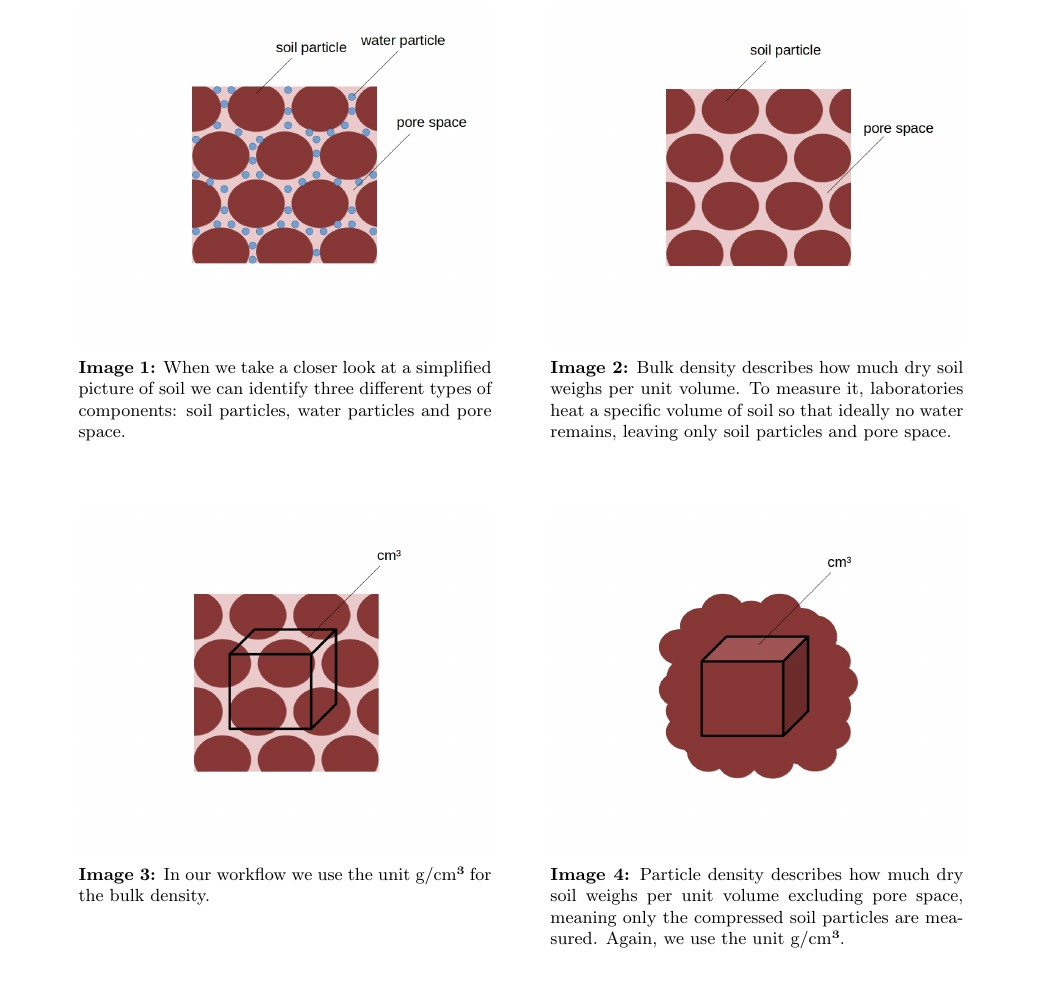

In [37]:
#change to figure instead of image


from IPython.display import Image, display
display(Image(filename='images/soil_final.jpg', width= 1100, height= 1100))

Now that we are familiar with certain physical quantities in the soil, let's examine the formulas needed to normalize the in-situ data. Formula 1 involves bulk density and particle density, concepts we have introduced above.

We can obtain the specific bulk density for our observation areas in Mozambique from [SoilGrids](https://soilgrids.org/)

The particle density is typically averaged at about 2.65 g/cm³. [(see this study)](https://www.sciencedirect.com/science/article/pii/S0016706105000431)




In [ ]:
import pandas as pd

area_names =["Buzi","Chokwé","Mabalane","Mabote","Muanza"]


bulk_dens = [1.25, 1.4, 1.4, 1.35, 1.25] #bulk density for "Buzi", "Chokwé", "Mabalane", "Mabote", "Muanza", given in g/cm³
poros = []

for i in bulk_dens:

    p = 1 -(i/2.65)
    poros.append(p) 



pd.DataFrame({"area": area_names, "porosity ( % ) ": poros})


,area,porosity ( g/cm³ )
0,Buzi,0.528302
1,Chokwé,0.471698
2,Mabalane,0.471698
3,Mabote,0.490566
4,Muanza,0.528302


$$
\text{Porosity} = \left(1 - \frac{\rho_{\text{bulk}}}{\rho_{\text{particle}}} \right) \times 100 \\

\\[2em]
\text{\emph{formula 1: Porosity}}
\\[3em]

\begin{aligned}
\text{Porosity} &\quad \text{: Total pore space in the soil - percentage of the total soil volume that is pore space (voids that could be filled with water or air) (in \%)} \\
\rho_{\text{bulk}} &\quad \text{: Bulk density, mass of soil per volume including pores (in g/cm³)} \\
\rho_{\text{particle}} &\quad \text{: Particle density, mass of the solid particles alone (in g/cm³)} \\
\end{aligned}
$$

$$
\text{SSM}_{\text{abs}} = \text{Porosity} - \frac{\text{SSM}_{\text{rel}}}{100}
\\[2em]
\text{\emph{formula 2: Absolute Soil Moisture}}
\\[3em]

\begin{aligned}
\text{SSM}_{\text{abs}} &\quad \text{: Absolute soil moisture, how much of the total soil volume is water (in \%)} \\
\text{SSM}_{\text{rel}} &\quad \text{: Relative soil moisture, how much of the pore space is filled with water (in m³/m³), i.e. volumetric space filled with water given in in-situ data}
\end{aligned}
$$


##### 2. Plotting the data

Visualizing the data can help to get a better intuition for further analysis and manipulation. Thus we plot the ascat and in-situ data for each observed area.

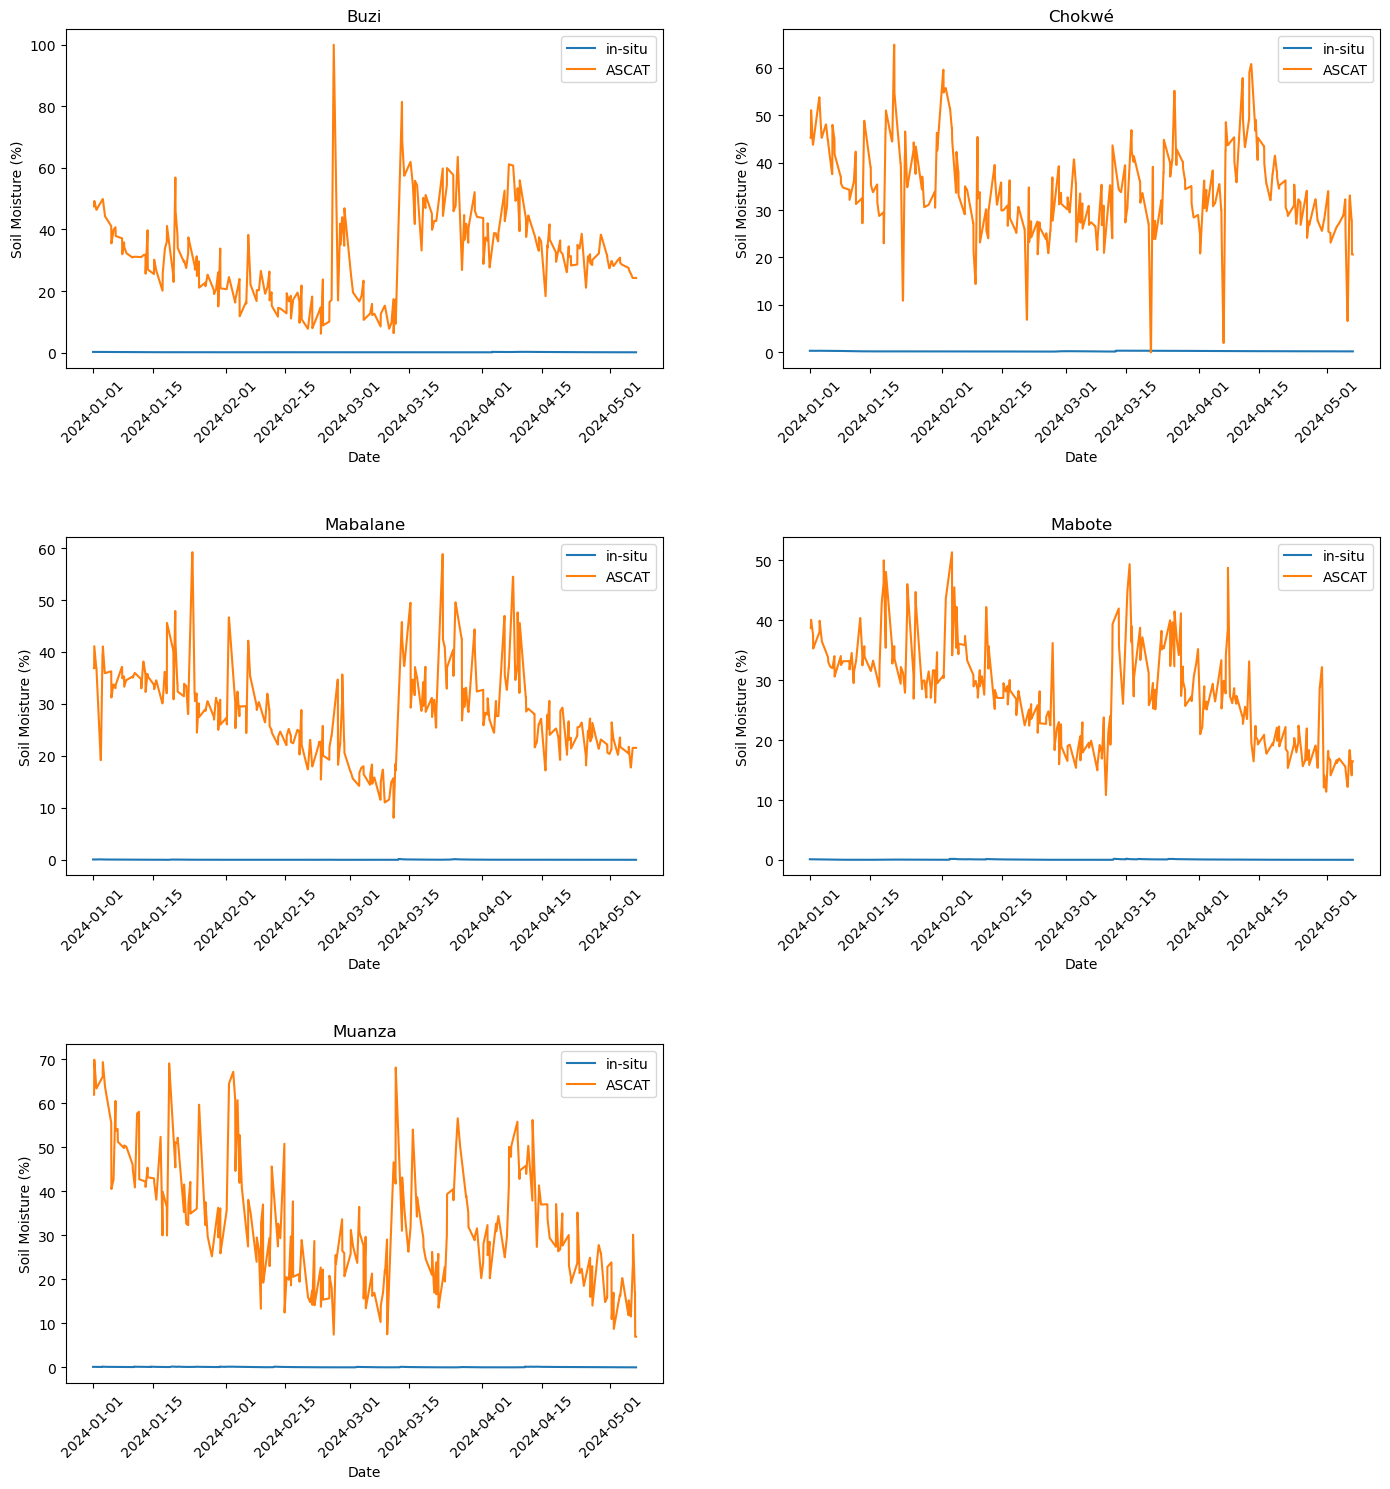

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Function to plot the line graph for multiple locations in one row
def plot_multiple_locations(data, location_names, start_date, end_date):
    data['datetime'] = pd.to_datetime(data['datetime'], errors="coerce")

    num_locations = len(location_names)
    cols = 2  # Number of plots per row
    rows = math.ceil(num_locations / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows), squeeze=False)

    for i, location_name in enumerate(location_names):
        row, col = divmod(i, cols)
        ax = axes[row][col]

        # Filter and process data
        location_data = data[data['location'] == location_name].copy()
        location_data = location_data[
            (location_data['datetime'] >= pd.to_datetime(start_date)) &
            (location_data['datetime'] <= pd.to_datetime(end_date))
        ]
        location_data['ascat %'] = location_data['ascat %'].bfill(limit=1)
        location_data = location_data.set_index("datetime")
        location_data['ascat interpolated'] = location_data['ascat %'].interpolate(method='time')

        # Plotting
        ax.plot(location_data.index, location_data['in-situ m³/m³'], label='in-situ', color='tab:blue')
        ax.plot(location_data.index, location_data['ascat interpolated'], label='ASCAT', color='tab:orange')
        ax.set_title(f'{location_name}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Soil Moisture (%)')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)

    # Hide unused subplots if number of locations is odd
    for j in range(i + 1, rows * cols):
        row, col = divmod(j, cols)
        fig.delaxes(axes[row][col])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.5) 
    plt.show()

# Example usage:
start_date = '2024-01-01 00:00:00'
end_date = '2024-05-07 00:00:00'
plot_multiple_locations(obs_data, area_names, start_date, end_date)


##### 3. Data analysis and manipulation 

At first glance the in-situ data in the plots above do not look like much. Now it is your turn to figure out the cause for this behaviour and what other aspects might be important to work out in order to get a better analysis for the data...